In [73]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from datetime import datetime
import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts


In [20]:
def recup_data_arrete(url):
        response = requests.get(url)
        if response.status_code != 200:
            return("pas de connexion")
        else:
            data = pd.read_csv(url)
            return(data)

In [25]:
urls = {
    '2010' : "https://www.data.gouv.fr/fr/datasets/r/d6cb1826-6cc8-4709-85fd-433db23aa951",    
    '2011' : "https://www.data.gouv.fr/fr/datasets/r/227149be-cd8b-4e59-a1a9-0840ef7f0a24",
    '2012' : "https://www.data.gouv.fr/fr/datasets/r/43864992-e79b-449e-9d7d-93dad9b9df59",
    '2013' : "https://www.data.gouv.fr/fr/datasets/r/f9c1da33-19f4-499d-88cc-b3c247484215",
    '2014' : "https://www.data.gouv.fr/fr/datasets/r/c68362d9-93ff-46bc-99a6-35d506855dae",    
    '2015' : "https://www.data.gouv.fr/fr/datasets/r/98cb1f80-f296-4eae-a0b3-f236fc0b9325",
    '2016' : "https://www.data.gouv.fr/fr/datasets/r/fbd87d0b-a504-49e2-be6e-66a96ca4e489",
    '2017' : "https://www.data.gouv.fr/fr/datasets/r/ab886886-9b64-47ca-8604-49c9910c0b74",
    '2018' : "https://www.data.gouv.fr/fr/datasets/r/8ba1889e-5496-47a6-8bf3-9371086dd65c",
    '2019' : "https://www.data.gouv.fr/fr/datasets/r/ed2e6cfa-1fe7-40a6-95bb-d9e6f99a78a0",
    '2020' : "https://www.data.gouv.fr/fr/datasets/r/d16ae5b1-6666-4caa-930c-7993c4cd4188",
    '2021' : "https://www.data.gouv.fr/fr/datasets/r/c23fe783-763f-4669-a9b7-9d1d199fcfcd",
    '2022' : "https://www.data.gouv.fr/fr/datasets/r/0fee8de1-c6de-4334-8daf-654549e53988",
    '2023' : "https://www.data.gouv.fr/fr/datasets/r/782aac32-29c8-4b66-b231-ab4c3005f574"
}
for key, value in urls.items():
    # Création du nom de l'objet en concaténant "data_" avec la clé
    nom_objet = "data_" + key

    # Création de l'objet avec le nom spécifié
    globals()[nom_objet] = recup_data_arrete(value)

In [47]:
def maj_dataframe(data_frame):
    data_frame['debut_validite_arrete'] = pd.to_datetime(data_frame['debut_validite_arrete'])
    data_frame['fin_validite_arrete'] = pd.to_datetime(data_frame['fin_validite_arrete'])
    data_frame['duree_validite_arrete'] = (data_frame['fin_validite_arrete'] - data_frame['debut_validite_arrete']).dt.days
    data_frame['annee'] = data_frame['debut_validite_arrete'].dt.year
    data_frame = data_frame[['id_arrete', 'id_zone', 'annee', 'numero_niveau', 'nom_niveau', 'duree_validite_arrete']]
    return(data_frame)

In [56]:
dataframes_maj = []
for annee in urls.keys():
    # Récupération du DataFrame correspondant à l'année
    df = globals().get(f'data_{annee}')
    
    # Vérification si le DataFrame existe
    if df is not None:
        # Application de la fonction maj_dataframe(df)
        df_maj = maj_dataframe(df)
             
        # Ajout du DataFrame mis à jour à la liste
        dataframes_maj.append(df_maj)

# Concaténation de tous les DataFrames avec le suffixe "_maj"
data_tous_arretes = pd.concat(dataframes_maj, axis=0)

In [69]:
data_agrege = data_tous_arretes[data_tous_arretes['nom_niveau']!="Absence de restriction"].groupby(['annee','nom_niveau']).agg(
        total_duree = ('duree_validite_arrete', 'sum'),
        nombre_observations=('nom_niveau', 'size')
    )

data_agrege = data_agrege.reset_index(level = ['annee','nom_niveau'])
data_agrege

,annee,nom_niveau,total_duree,nombre_observations
0,2010,Alerte,1041.0,12
1,2010,Arrêt des prélèvements non prioritaires,122.0,3
2,2010,Crise,531.0,8
3,2010,Crise modérée,404.0,8
4,2010,Crise renforcée,1982.0,10
...,...,...,...,...
57,2023,Alerte,36062.0,595
58,2023,Alerte renforcée,23108.0,372
59,2023,Crise,7962.0,126
60,2023,Vigilance,121080.0,1895


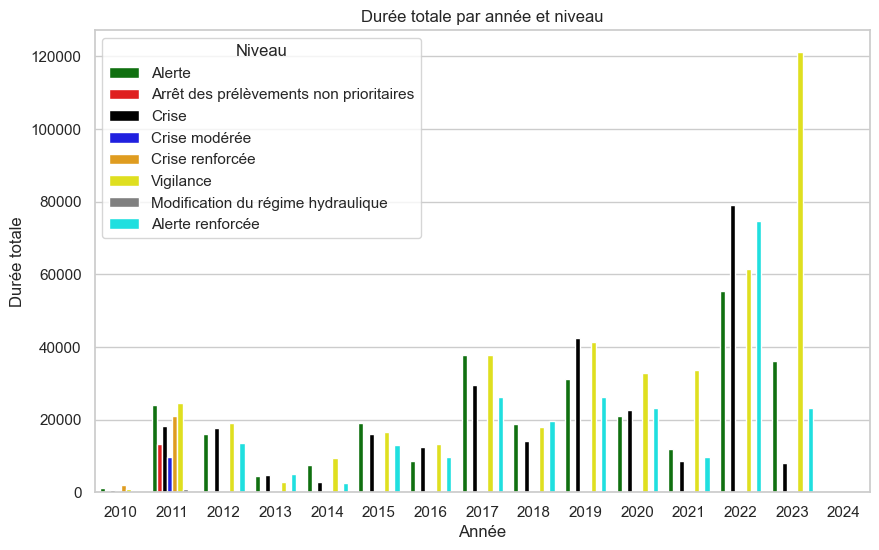

In [74]:
# Couleurs pour chaque niveau
couleurs = {
            'Crise modérée' : "blue", 
            'Crise' : "black",  
            'Vigilance' : "yellow",  
            'Alerte' : "green", 
            'Arrêt des prélèvements non prioritaires' : "red",  
            'Crise renforcée' : "orange", 
            'Absence de restriction' : "purple",  
            'Modification du régime hydraulique' : "grey", 
            'Alerte renforcée' : "cyan" 
            }  

# Graphique à barres empilées
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

sns.barplot(
    data=data_agrege,
    x='annee',
    y='total_duree',
    hue='nom_niveau',
    palette=couleurs,
    estimator=sum,
    errorbar=None
)

plt.title('Durée totale par année et niveau')
plt.xlabel('Année')
plt.ylabel('Durée totale')
plt.legend(title='Niveau')

plt.show()

In [83]:
data_pivot = data_agrege.pivot(index='annee', columns='nom_niveau', values='total_duree').reset_index()
data_pivot.head()

nom_niveau,annee,Alerte,Alerte renforcée,Arrêt des prélèvements non prioritaires,Crise,Crise modérée,Crise renforcée,Modification du régime hydraulique,Vigilance
0,2010,1041.0,NaN,122.0,531.0,404.0,1982.0,NaN,872.0
1,2011,24146.0,NaN,13390.0,18236.0,9750.0,21049.0,774.0,24562.0
2,2012,15926.0,13457.0,NaN,17705.0,NaN,NaN,NaN,18973.0
3,2013,4364.0,4912.0,NaN,4724.0,NaN,NaN,NaN,2688.0
4,2014,7594.0,2443.0,NaN,2774.0,NaN,NaN,NaN,9512.0


In [89]:

(
    Bar(
        opts.InitOpts(
            #theme = ThemeType.DARK,
            width = "1024px",
            height = "600px"
        )
    )
    .add_xaxis(data_pivot.annee.tolist())
    .add_yaxis(
        "Vigilance",
        data_pivot["Vigilance"].tolist(),
        stack= "Ad",
        color="black",
    .add_yaxis(
        "Alerte",
        data_pivot["Alerte"].tolist(),
        stack= "Ad",
        color="black",
    ).add_yaxis(
        "Alerte renforcée",
        data_pivot["Alerte renforcée"].tolist(),
        stack= "Ad",
        color="black",
    )
    ).add_yaxis(
        "Arrêt des prélèvements non prioritaires",
        data_pivot["Arrêt des prélèvements non prioritaires"].tolist(),
        stack= "Ad",
        color="black",
    ).add_yaxis(
        "Crise",
        data_pivot["Crise"].tolist(),
        stack= "Ad",
        color="black",
    )
    .add_yaxis(
        "Crise modérée",
        data_pivot["Crise modérée"].tolist(),
        stack= "Ad",
        color="black",
    )
    .add_yaxis(
        "Crise renforcée	",
        data_pivot["Crise renforcée	"].tolist(),
        stack= "Ad",
        color="grey",
    )
   .render_notebook() # use .render_notebook() within Jupyter notebooks
)